# Задание 0. Выбрать любой подходящий датасет для классификации. В данном случае MNIST из keras

In [118]:
# Подключаем библиотеки и конектимся к гугл-диску
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
# Грузим данные
data_train = pd.read_csv('/content/drive/MyDrive/data/mnist_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/data/mnist_test.csv')

# Ограничим набор данных, чтобы обучение проходило быстрее
data_train = data_train[:2000]
data_test = data_test[:400]

#Преобразуем датасет в numpy массив
data_train.to_numpy()

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [120]:
# отделяем данные от меток
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()
del data_train_copy['label']
X_train = data_train_copy
del data_test_copy['label']
X_test = data_test_copy
del data_train_copy
del data_test_copy

In [121]:
#Смотрим, что получилось
X_train.shape, X_test.shape

((2000, 784), (400, 784))

In [122]:
# Проводим нормализацию
X_train /= 255
X_test /= 255

In [123]:
# Кодируем метки классов
encoding = OneHotEncoder(sparse=False, handle_unknown='error')
labels = pd.concat([data_train[['label']], data_test[['label']]])
encoding.fit(labels)
y_train = pd.DataFrame(encoding.transform(data_train[['label']]))
y_test = pd.DataFrame(encoding.fit_transform(data_test[['label']]))
y_train

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
# Приводим все датасеты к массивам
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()

# Задание 1. Реализация однослойного перцептрона без использования библиотек

In [125]:
#Задаём функцию активации
def relu(x):
    return (x > 0) * x

def relu_two_deriv(output):
    return output>0

In [126]:
# Настраиваем модель предсказания сети
def model_prediction(input, weights_0_1, weights_1_2):
  layer_0 = input
  layer_1 = relu(np.dot(layer_0,weights_0_1))
  layer_2 = np.dot(layer_1,weights_1_2)
  return layer_2

In [127]:
# Реализуем стохастический градиентный спуск

np.random.seed(1)

learning_rate = 0.005
hidden_size = 40
input_size = 784
num_labels = 10

weights_input_hidden = (2*np.random.random((input_size,hidden_size)) - 1) / np.sqrt(input_size) # веса между входным и скрытым слоями
weights_hidden_output = (2*np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size) # веса между скрытым и выходным слоями

array_iteration = []
array_error = []
array_accuracy = []

for iteration in range(6):
   error = 0
   for i in range(len(X_train)):
     # прямой проход
     input_layer = X_train[i:i+1]
     hidden_layer = relu(np.dot(input_layer,weights_input_hidden))
     output_layer = np.dot(hidden_layer,weights_hidden_output)

     error = error + np.sum((output_layer - y_train[i:i+1]) ** 2)

     # обратный проход
     diff_between_output_hidden = 2*(output_layer - y_train[i:i+1])
     weight_hidden_output_corrections = hidden_layer.T.dot(diff_between_output_hidden) # величина коррекции для весов между layer_1 и layer_2

     diff_between_input_hidden = diff_between_output_hidden.dot(weights_hidden_output.T)*relu_two_deriv(hidden_layer)
     weight_input_hidden_corrections = input_layer.T.dot(diff_between_input_hidden)

     weights_hidden_output = weights_hidden_output - learning_rate * weight_hidden_output_corrections
     weights_input_hidden = weights_input_hidden - learning_rate * weight_input_hidden_corrections

   if(iteration % 2 == 0):
      print("Error:", str(error))
      array_iteration.append(iteration)
      array_error.append(error)
      goal_idx = np.argmax(y_train[:100], axis=1)
      y_prediction = model_prediction(X_train[:100], weights_input_hidden, weights_hidden_output)
      pred_idx = np.argmax(y_prediction, axis=1)
      accuracy = accuracy_score(goal_idx ,pred_idx)
      array_accuracy.append(accuracy)
      print("Acc:", str(accuracy))

Error: 983.3734915041077
Acc: 0.88
Error: 468.459255382291
Acc: 0.91
Error: 365.35172186638096
Acc: 0.95


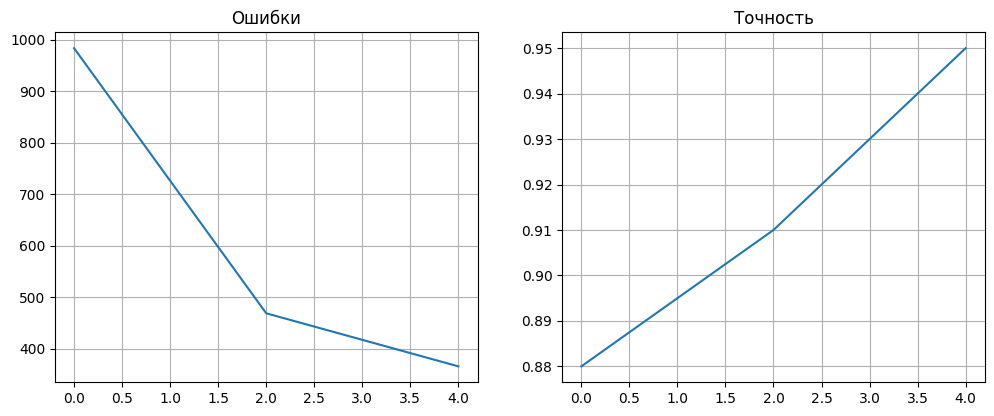

In [128]:
# Строим графики по нему

graph = plt.figure(figsize=(12, 10), constrained_layout=False)

error_range = np.linspace(0.18, 0)

subgraph_1 = graph.add_subplot(221)
subgraph_1.plot(array_iteration, array_error)
subgraph_1.set_title('Ошибки')
plt.grid()

subgraph_2 = graph.add_subplot(222)
subgraph_2.plot(array_iteration, array_accuracy)
subgraph_2.set_title('Точность')
plt.grid()

In [129]:
# Теперь пакетный градиентный спуск

learning_rate = 0.005
hidden_size = 64
input_size = 784
num_labels = 10
batch_size = 32
n_iterations = len(X_train) // batch_size
epochs_count  = 10

weights_input_hidden_batch = (2*np.random.random((input_size,hidden_size)) - 1) / np.sqrt(input_size) #веса между входным и скрытым слоями
weights_hidden_output_batch = (2*np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size) #веса между скрытым и выходным слоями

array_iteration_batch = []
array_error_batch = []
array_accuracy_batch = []


for epoch in range(epochs_count):
   error = 0
   for i in range(n_iterations):
     # промой проход
     input_layer_batch = X_train[i * batch_size:(i+1) * batch_size]
     hidden_layer_batch = relu(np.dot(input_layer_batch, weights_input_hidden_batch))
     output_layer_batch = np.dot(hidden_layer_batch, weights_hidden_output_batch)

     error += np.mean((output_layer_batch - y_train[i * batch_size:(i+1) * batch_size]) ** 2)

     # обратный проход
     diff_between_output_hidden_batch = 2*(output_layer_batch - y_train[i * batch_size:(i+1) * batch_size])
     weight_output_hidden_batch_corrections = hidden_layer_batch.T.dot(diff_between_output_hidden_batch) #величина коррекции для весов между layer_1 и layer_2

     diff_between_input_hidden_batch = diff_between_output_hidden_batch.dot(weights_hidden_output_batch.T)*relu_two_deriv(hidden_layer_batch)
     weight_input_hidden_batch_corrections = input_layer_batch.T.dot(diff_between_input_hidden_batch)

     weights_hidden_output_batch = weights_hidden_output_batch - learning_rate * weight_output_hidden_batch_corrections
     weights_input_hidden_batch = weights_input_hidden_batch - learning_rate * weight_input_hidden_batch_corrections

   if(epoch % 2 == 0):
      print("Error:", error / n_iterations) # MAE
      array_iteration_batch.append(epoch)
      array_error_batch.append(error)
      goal_idx = np.argmax(y_train[:100], axis=1)
      y_pred = model_prediction(X_train[:100], weights_input_hidden_batch, weights_hidden_output_batch)
      pred_idx = np.argmax(y_pred, axis=1)
      accuracy = accuracy_score(goal_idx ,pred_idx)
      array_accuracy_batch.append(accuracy)
      print("Acc:", str(accuracy))


Error: 0.05553970137197859
Acc: 0.86
Error: 0.022111549972350875
Acc: 0.92
Error: 0.01713666155828357
Acc: 0.94
Error: 0.014623429800524402
Acc: 0.96
Error: 0.012639067935195616
Acc: 0.96


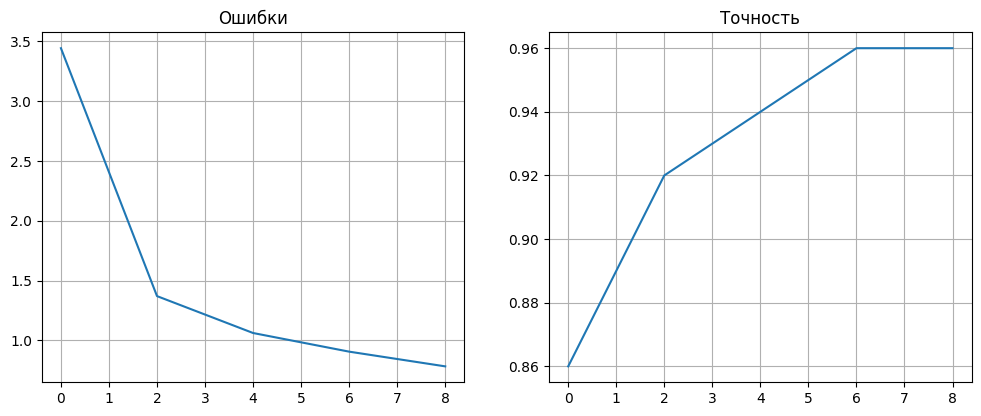

In [130]:
# Построим графики

graph_batch = plt.figure(figsize=(12, 10), constrained_layout=False)

error_range = np.linspace(0.15, 0)

subgraph_batch_1 = graph_batch.add_subplot(221)
subgraph_batch_1.plot(array_iteration_batch, array_error_batch)
subgraph_batch_1.set_title('Ошибки')
plt.grid()

subgraph_batch_2 = graph_batch.add_subplot(222)
subgraph_batch_2.plot(array_iteration_batch, array_accuracy_batch)
subgraph_batch_2.set_title('Точность')
plt.grid()

In [131]:
# Предсказание
goal_idx = np.argmax(y_test, axis=1)
y_pred = model_prediction(X_test, weights_input_hidden_batch, weights_hidden_output_batch)
pred_idx = np.argmax(y_pred, axis=1)
acc = accuracy_score(goal_idx ,pred_idx)
array_accuracy_batch.append(acc)
print("Test Acc:", acc)

Test Acc: 0.9175


# Задание 2. Сравнить результаты с использованием однослойного перцептрона из sklearn

In [132]:
from sklearn.linear_model import Perceptron

y_train = data_train['label']
y_test = data_test['label']

model = Perceptron(random_state=77)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.8475


# Задание 3. Сравнить результаты с использованием многослойного перцептрона из sklearn

In [133]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.915
